In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_circles, make_s_curve
from umap import UMAP
import torch
import matplotlib.pyplot as plt
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
from dpa.dpa_fit import MDDPA

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.datasets import fetch_openml
mn = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
X_full = mn.data.astype(np.float32) / 255.0
y_full = mn.target.astype(int)
print("Loaded MNIST from openml:", X_full.shape)


# 2) Subsample up to 5,000 observations
n_sub = min(1000, X_full.shape[0])
rng = np.random.RandomState(42)
idx = rng.choice(X_full.shape[0], size=n_sub, replace=False)
X_sub = X_full[idx]
y_sub = y_full[idx]

# 3) Split into train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, test_size=0.3, random_state=42
)


Loaded MNIST from openml: (70000, 784)


In [3]:
X_train.shape, X_test.shape

((700, 784), (300, 784))

In [4]:
# 3. Fit methods
latent_dim = 2
umap_model11 = UMAP(n_components=latent_dim, min_dist = 0.5, n_neighbors = 15, random_state=42).fit(X_train)
umap_model12 = UMAP(n_components=latent_dim, min_dist = 0.75, n_neighbors = 15, random_state=42).fit(X_train)
umap_model13 = UMAP(n_components=latent_dim, min_dist = 1, n_neighbors = 15, random_state=42).fit(X_train)
umap_model21 = UMAP(n_components=latent_dim, min_dist = 0.5, n_neighbors = 30, random_state=42).fit(X_train)
umap_model22 = UMAP(n_components=latent_dim, min_dist = 0.75, n_neighbors = 30, random_state=42).fit(X_train)
umap_model23 = UMAP(n_components=latent_dim, min_dist = 1, n_neighbors = 30, random_state=42).fit(X_train)


X_train_umap11 = umap_model11.transform(X_train)
X_train_umap12 = umap_model12.transform(X_train)
X_train_umap13 = umap_model13.transform(X_train)
X_train_umap21 = umap_model21.transform(X_train)
X_train_umap22 = umap_model22.transform(X_train)
X_train_umap23 = umap_model23.transform(X_train)

X_test_umap11 = umap_model11.transform(X_test)
X_test_umap12 = umap_model12.transform(X_test)
X_test_umap13 = umap_model13.transform(X_test)
X_test_umap21 = umap_model21.transform(X_test)
X_test_umap22 = umap_model22.transform(X_test)
X_test_umap23 = umap_model23.transform(X_test)


/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-

In [5]:
X_test_pca_inv11 = umap_model11.inverse_transform(X_test_umap11)
X_test_pca_inv12 = umap_model12.inverse_transform(X_test_umap12)
X_test_pca_inv13 = umap_model13.inverse_transform(X_test_umap13)
X_test_pca_inv21 = umap_model21.inverse_transform(X_test_umap21)
X_test_pca_inv22 = umap_model22.inverse_transform(X_test_umap22)
X_test_pca_inv23 = umap_model23.inverse_transform(X_test_umap23)

In [7]:

# 7. Fit distillers and compute MSE
errors = {
    'UMAP (md=0.5, nn=15)':       mean_squared_error(X_test, X_test_pca_inv11),
    'UMAP (md=0.75, nn=15)':      mean_squared_error(X_test, X_test_pca_inv12),
    'UMAP (md=1, nn=15)':         mean_squared_error(X_test, X_test_pca_inv13),
    'UMAP (md=0.5, nn=30)':       mean_squared_error(X_test, X_test_pca_inv21),
    'UMAP (md=0.75, nn=30)':      mean_squared_error(X_test, X_test_pca_inv22),
    'UMAP (md=1, nn=30)':         mean_squared_error(X_test, X_test_pca_inv23),
}

distillers = {
    'UMAP + MDDPA (md=0.5, nn=15)':      X_train_umap11,
    'UMAP + MDDPA (md=0.75, nn=15)':      X_train_umap12,
    'UMAP + MDDPA (md=1, nn=15)':         X_train_umap13,
    'UMAP + MDDPA (md=0.5, nn=30)':       X_train_umap21,
    'UMAP + MDDPA (md=0.75, nn=30)':      X_train_umap22,
    'UMAP + MDDPA (md=1, nn=30)':         X_train_umap23,
}

In [8]:
errors

{'UMAP (md=0.5, nn=15)': 0.07388801127672195,
 'UMAP (md=0.75, nn=15)': 0.07188130170106888,
 'UMAP (md=1, nn=15)': 0.0695347785949707,
 'UMAP (md=0.5, nn=30)': 0.07591178268194199,
 'UMAP (md=0.75, nn=30)': 0.07304449379444122,
 'UMAP (md=1, nn=30)': 0.06989352405071259}

In [9]:
for name, emb_train in distillers.items():
    dist = MDDPA(data_dim = X_sub.shape[1], num_layer=2, latent_dims = list(np.arange(latent_dim+2, -1, -1)), device=device)
    dist.train(x=torch.Tensor(X_train, device=device), z=torch.Tensor(emb_train, device=device), batch_size = 250, num_epochs=500)
    X_rec = dist.reconstruct(torch.Tensor(X_test).to(device), k=latent_dim, mean=True).cpu().detach().numpy()
    errors[name] = mean_squared_error(X_test, X_rec)
    print(dist.sample_type)

# 8. Create results table
results = pd.DataFrame([
    {'Method': m, 'Reconstruction MSE': mse}
    for m, mse in errors.items()
])

# Display to user
results

Running on CPU.

Start training with 3 batches each of size 250.

[Epoch 1] 9.4627, 9.2646, 9.1425, 9.3549, 9.5942
 pred 	19.0950, 20.0908, 20.9934, 22.3051, 23.5099
 var 	19.2645, 21.6524, 23.7018, 25.9004, 27.8314

[Epoch 100] 5.3319, 5.5827, 5.9165, 6.0831, 6.5372
 pred 	12.4976, 14.1211, 15.4136, 16.8340, 18.1497
 var 	14.3314, 17.0768, 18.9941, 21.5017, 23.2251

[Epoch 200] 5.1216, 5.2960, 5.4927, 5.5938, 5.9191
 pred 	10.3922, 11.7915, 13.1012, 14.2636, 15.4917
 var 	10.5412, 12.9911, 15.2170, 17.3397, 19.1452

[Epoch 300] 5.1252, 5.1443, 5.1808, 5.3807, 5.5626
 pred 	9.6568, 10.5424, 11.3431, 12.5292, 13.7366
 var 	9.0631, 10.7960, 12.3246, 14.2970, 16.3481

[Epoch 400] 5.1123, 5.0738, 5.0495, 5.3095, 5.3808
 pred 	9.5016, 10.0259, 10.5857, 11.3596, 12.3739
 var 	8.7786, 9.9043, 11.0723, 12.1002, 13.9863

[Epoch 500] 4.9927, 4.9540, 4.9856, 5.1552, 5.2662
 pred 	9.4245, 9.7664, 10.1345, 10.7476, 11.5196
 var 	8.8636, 9.6247, 10.2978, 11.1848, 12.5069

parallel
Running on CPU.

S

,Method,Reconstruction MSE
0,"UMAP (md=0.5, nn=15)",0.073888
1,"UMAP (md=0.75, nn=15)",0.071881
2,"UMAP (md=1, nn=15)",0.069535
3,"UMAP (md=0.5, nn=30)",0.075912
4,"UMAP (md=0.75, nn=30)",0.073044
5,"UMAP (md=1, nn=30)",0.069894
6,"UMAP + MDDPA (md=0.5, nn=15)",0.065083
7,"UMAP + MDDPA (md=0.75, nn=15)",0.065983
8,"UMAP + MDDPA (md=1, nn=15)",0.067270
9,"UMAP + MDDPA (md=0.5, nn=30)",0.065179


In [10]:
results.sort_values(by='Reconstruction MSE', ascending=True)


,Method,Reconstruction MSE
6,"UMAP + MDDPA (md=0.5, nn=15)",0.065083
9,"UMAP + MDDPA (md=0.5, nn=30)",0.065179
10,"UMAP + MDDPA (md=0.75, nn=30)",0.065223
11,"UMAP + MDDPA (md=1, nn=30)",0.065322
7,"UMAP + MDDPA (md=0.75, nn=15)",0.065983
8,"UMAP + MDDPA (md=1, nn=15)",0.067270
2,"UMAP (md=1, nn=15)",0.069535
5,"UMAP (md=1, nn=30)",0.069894
1,"UMAP (md=0.75, nn=15)",0.071881
4,"UMAP (md=0.75, nn=30)",0.073044


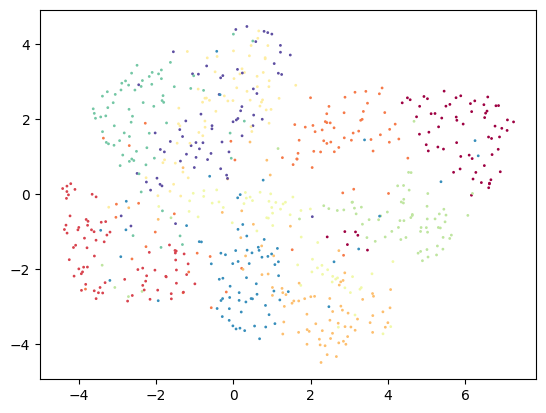

In [21]:
plt.scatter(X_train_umap11[:, 0], X_train_umap11[:, 1], c = y_train, s=1, cmap='Spectral')

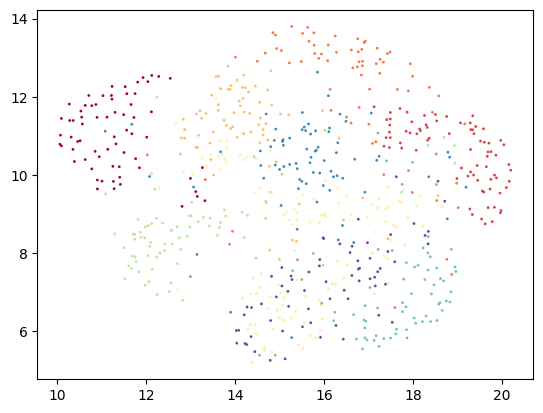

In [22]:
plt.scatter(X_train_umap21[:, 0], X_train_umap21[:, 1], c = y_train, s=1, cmap='Spectral')

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

md = 3
# dt11 = RandomForestClassifier(max_depth=md).fit(X_train_umap11, y_train)
# dt12 = RandomForestClassifier(max_depth=md).fit(X_train_umap12, y_train)
# dt13 = RandomForestClassifier(max_depth=md).fit(X_train_umap13, y_train)
# dt21 = RandomForestClassifier(max_depth=md).fit(X_train_umap21, y_train)
# dt22 = RandomForestClassifier(max_depth=md).fit(X_train_umap22, y_train)
# dt23 = RandomForestClassifier(max_depth=md).fit(X_train_umap23, y_train)

dt11 = KNeighborsClassifier().fit(X_train_umap11, y_train)
dt12 = KNeighborsClassifier().fit(X_train_umap12, y_train)
dt13 = KNeighborsClassifier().fit(X_train_umap13, y_train)
dt21 = KNeighborsClassifier().fit(X_train_umap21, y_train)
dt22 = KNeighborsClassifier().fit(X_train_umap22, y_train)
dt23 = KNeighborsClassifier().fit(X_train_umap23, y_train)


In [12]:
print(accuracy_score(dt11.predict(X_test_umap11), y_test))
print(accuracy_score(dt12.predict(X_test_umap12), y_test))
print(accuracy_score(dt13.predict(X_test_umap13), y_test))
print(accuracy_score(dt21.predict(X_test_umap21), y_test))
print(accuracy_score(dt22.predict(X_test_umap22), y_test))
print(accuracy_score(dt23.predict(X_test_umap23), y_test))

0.69
0.6633333333333333
0.6466666666666666
0.6533333333333333
0.6366666666666667
0.59
